# Example: Classification using `QNNClassifier`

In this notebook we show how to use the `QNNClassifier` for classification of points in 2D Space.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from squlearn import Executor
from squlearn.encoding_circuit import ChebyshevRx
from squlearn.observables import SummedPaulis
from squlearn.qnn import QNNClassifier, SquaredLoss
from squlearn.optimizers import SLSQP

In [2]:
executor = Executor("statevector_simulator")

## `QNNClassifier` Setup

We start by defining a parameterized quantum circuit (PQC)

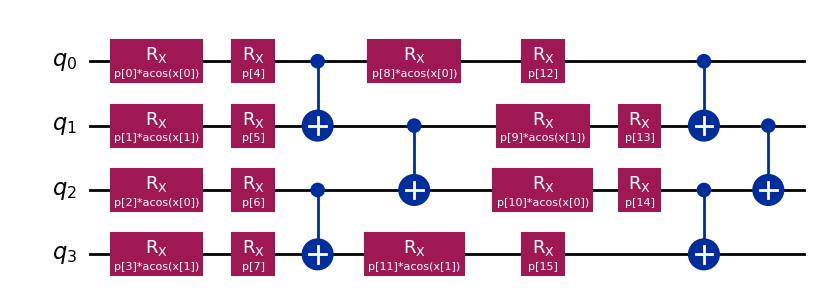

In [3]:
nqubits = 4
number_of_layers = 2

pqc = ChebyshevRx(nqubits, 2, num_layers=number_of_layers)
pqc.draw("mpl")

We also need an observable

In [4]:
cost_op = SummedPaulis(nqubits)
print(cost_op)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[3]),
 ParameterExpression(1.0*p[4])])


Now we can create the `QNNClassifier` with the PQC and cost operator. We also specify `SquaredLoss` and `SLSQP` as the loss function and optimizer respectively. Finally we specify random initial parameters for both, the PQC and cost operator.

In [5]:
np.random.seed(24)
param_ini = np.array(
    [
        2.01582474e00,
        5.43896741e00,
        3.44229491e-01,
        -1.21692970e00,
        -1.44331612e00,
        -6.71489763e00,
        1.99150765e00,
        1.23780761e00,
        5.36280143e-03,
        2.82742143e00,
        -2.16244439e00,
        -1.07058225e00,
        3.28792107e-01,
        -7.83072396e-01,
        4.70501263e00,
        1.16875440e00,
    ]
)
param_op_ini = np.array([0.54683887, 0.12040171, 0.49628427, 1.70839648, -1.52245643])
clf = QNNClassifier(
    pqc, cost_op, executor, SquaredLoss(), SLSQP(options={"maxiter": 25}), param_ini, param_op_ini
)

## Generate Dataset

We will use the `make_blobs` dataset from scikit-learn with two classes and 60 samples. We split the set into one for training and one for testing.

In [6]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X, y = make_blobs(60, centers=2, random_state=0)
X = MinMaxScaler((-0.9, 0.9)).fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Training

Now we can fit the `QNNClassifier`

In [7]:
clf.fit(X_train, y_train)

fit: 100%|██████████| 25/25 [01:23<00:00,  3.21s/it]

## Evaluation

Let's check the final trained parameters

In [8]:
print("Result PQC params:", clf.param)
print("Result operator params:", clf.param_op)

Result PQC params: [ 1.84832746  5.57816848  0.26269309 -1.25372704 -1.24061828 -6.86335146
  1.80251021  1.32628121  0.02710083  2.98612724 -2.39540065 -1.10737959
  0.25379095 -0.95737795  5.02479789  1.257228  ]
Result operator params: [ 0.55668155  0.14434477  0.59801022  2.48842503 -1.82330045]


Also let's check the `QNNClassifier`'s performance on the test set.

In [9]:
clf.score(X_test, y_test)

0.9

Finally let's visualize the training and test data, as well as the decision boundary of the `QNNClassifier`.

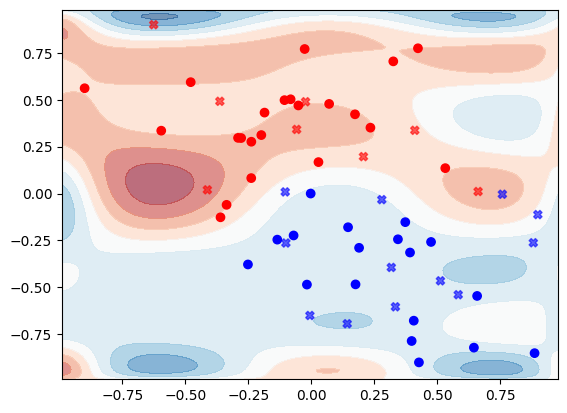

In [10]:
from matplotlib.colors import ListedColormap

xx, yy = np.meshgrid(np.arange(-0.99, 0.99, 0.01), np.arange(-0.99, 0.99, 0.01))

cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])

Z = clf.predict_proba(np.column_stack([xx.ravel(), yy.ravel()]))[:, 1]
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cm, alpha=0.6)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
# and testing points
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, marker="X")